In [1]:
%matplotlib inline
import os
from matplotlib import pyplot, patches
from PIL import Image
from trainer import model, task
from tensorflow.python.tools import inspect_checkpoint
import tensorflow as tf
import numpy as np
from pandas.io.parsers import read_csv

In [2]:
IMG_SIZE = 96
TEST_DATA = 'data/test.csv'
CKPT_DIR = './ckpt/'
MODELS = {
    'simple': 'c_32_64_128_k_3_3_3_p_07_lr_0003',
    'augmented': 'c_32_64_128_k_3_3_3_p_07_lr_0003_aug',
}
OUT_NAME = 'frozen_model'

In [3]:
df = read_csv(TEST_DATA)
df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
imgs = np.vstack(df['Image'].values)

The first thing we need to do is to load the saved graph.

In [4]:
def load_graph(frozen_graph_filename):
    """
    Reads a graph saved in a ProtoBuf file (.pb)
    :returns graph
    """
    with tf.gfile.GFile(frozen_graph_filename) as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def, 
            input_map=None, 
            return_elements=None, 
            name='prefix', 
            op_dict=None, 
            producer_op_list=None
        )
    return graph

In [5]:
graphs = dict()
for name, job_dir in MODELS.iteritems():
    graphs[name] = load_graph(os.path.join(CKPT_DIR, job_dir, 'export', '{}.pb'.format(OUT_NAME)))
for op in graphs.values()[0].get_operations():
    print(op.name)

prefix/input
prefix/conv_0/weights
prefix/conv_0/weights/read
prefix/conv_0/biases
prefix/conv_0/biases/read
prefix/conv_0/Conv2D
prefix/conv_0/add
prefix/conv_0/Relu
prefix/conv_0/MaxPool
prefix/conv_0/Dropout/Identity
prefix/conv_1/weights
prefix/conv_1/weights/read
prefix/conv_1/biases
prefix/conv_1/biases/read
prefix/conv_1/Conv2D
prefix/conv_1/add
prefix/conv_1/Relu
prefix/conv_1/MaxPool
prefix/conv_1/Dropout/Identity
prefix/conv_2/weights
prefix/conv_2/weights/read
prefix/conv_2/biases
prefix/conv_2/biases/read
prefix/conv_2/Conv2D
prefix/conv_2/add
prefix/conv_2/Relu
prefix/conv_2/MaxPool
prefix/conv_2/Dropout/Identity
prefix/Reshape/shape
prefix/Reshape
prefix/fc_4/fully_connected/weights
prefix/fc_4/fully_connected/weights/read
prefix/fc_4/fully_connected/biases
prefix/fc_4/fully_connected/biases/read
prefix/fc_4/fully_connected/MatMul
prefix/fc_4/fully_connected/BiasAdd
prefix/fc_4/fully_connected/Relu
prefix/fc_4/Dropout/Identity
prefix/out/fully_connected/weights
prefix/out

As we can see, all the ops related to the training of the graph (loss, square of loss, gradients etc...) have been removed and what's left are only the necessary ops to make predictions.

In [6]:
with tf.Session() as sess:
    filename_queue = tf.train.string_input_producer(['./data/pred.tfrecords'], num_epochs=1)
    reader = tf.TFRecordReader()
    image = model.decode_single_example(reader, filename_queue)
    sess.run([tf.local_variables_initializer(), 
              tf.global_variables_initializer()])
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    imgs = []
    labels = []
    try:
        while True:
            [(img, label)] = sess.run([image])
            imgs.append(img)
            labels.append(label)
    except tf.errors.OutOfRangeError, e:
        coord.request_stop(e)
    finally:
        coord.request_stop()
        coord.join(threads)
    imgs = np.asarray(imgs)
    labels = np.asarray(labels)

In [7]:
def predict(graph, imgs):
    """
    Make prediction for a given graph.
    :param graph: the prediction graph
    :param imgs: the images the predict. A numpy array of shape (?, 96, 96, 1)
    """
    ins = graph.get_tensor_by_name('prefix/input:0')
    preds = graph.get_tensor_by_name('prefix/out/fully_connected/BiasAdd:0')

    with tf.Session(graph=graph) as sess:
        preds_out = sess.run(preds, feed_dict={
            ins: imgs.reshape(imgs.shape[0], 96, 96, 1) / 255.
        })
    return preds_out

In [8]:
predictions = dict()
for name, graph in graphs.iteritems():
    predictions[name] = predict(graph, imgs)

Let us define some utility functions to plot our images and the predicted keypoints.

In [57]:
COLORS = [(0, 1, 0, 0.4), (0, 0, 1, 0.4)]
def plot_sample(imgs, keypoints, indices=None, labels=None, n_rows=3, n_cols=3):
    """
    Plots a random subset of size n_rows * n_cols of the test images.
    :param imgs: the complete set of test images.
    :param keypoints: a dict of model associated with its set of predicted keypoints.
    :param n_rows: the number of rows in the plot.
    :param n_cols: the number of columns in the plot.
    """
    sample_size = n_rows * n_cols
    if indices is None:
        indices = np.random.choice(range(imgs.shape[0]), sample_size, False)
    fig = pyplot.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, xticks=[], yticks=[])
        ax.title.set_text('image #{}'.format(idx))
        ax.imshow(np.reshape(imgs[idx, :], (IMG_SIZE, IMG_SIZE)), 'gray')
        for j, p in enumerate(keypoints.values()):
            pred = p[idx, :]
            ax.scatter(pred[0::2] * 48 + 48, pred[1::2] * 48 + 48, marker='x', s=50, color=COLORS[j])
            if labels is not None:
                ax.scatter(labels[idx, 0::2] * 48 + 48, labels[idx, 1::2] * 48 + 48, marker='x', s=50, color=(1, 0, 0, 0.5))
    handles = []
    for j, name in enumerate(keypoints.iterkeys()):
        handles.append(patches.Patch(color=COLORS[j], label=name))
    if labels is not None:
        handles.append(patches.Patch(color=(1, 0, 0, 0.5), label='label'))
    pyplot.legend(handles=handles)
    pyplot.show()

Let us have a look at some radomly picked results.

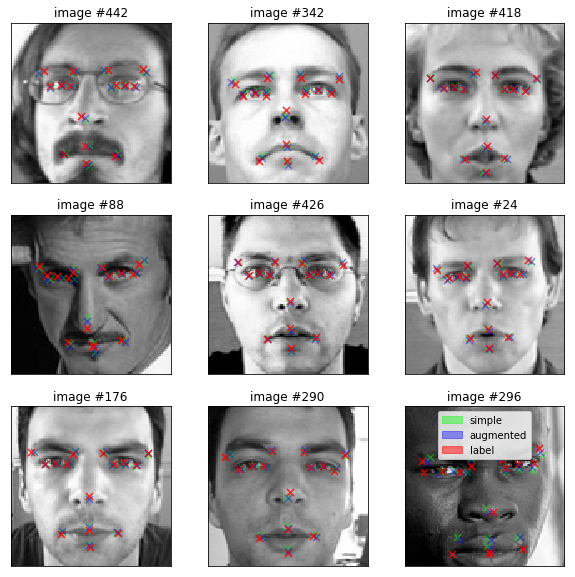

In [65]:
plot_sample(imgs, predictions, None, labels)

This seems promising, even though obviously not perfect. One thing to observe is how bad image 296 is predicted. Another thing is to notice that picking the best model between 'simple' and 'augmented' using our eyes only would be a fairly tricky exercise. Luckily, this was chosen using an objective criteria during training.

Let us have a quick look at the distribution of individual squared loss.

(array([  68.,  114.,   90.,   53.,   44.,   27.,   17.,   19.,   13.,
          15.,   12.,    7.,    4.,    7.,    7.,    0.,    3.,    2.,
           5.,    3.,    1.,    3.,    3.,    0.,    2.,    0.,    2.,
           2.,    1.,    1.,    0.,    1.,    0.,    2.,    2.,    0.,
           0.,    0.,    0.,    1.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([ 0.00012744,  0.00028038,  0.00043333,  0.00058627,  0.00073922,
         0.00089217,  0.00104511,  0.00119806,  0.00135101,  0.00150395,
         0.0016569 ,  0.00180985,  0.00196279,  0.00211574,  0.0

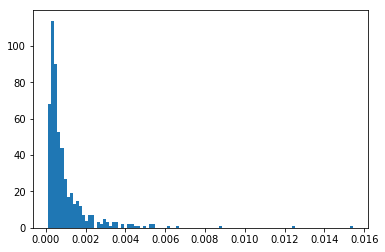

In [75]:
loss = np.mean(np.square(predictions['augmented'] - labels), axis=1)
pyplot.hist(loss, bins=100)

Given a validation loss of roughly 1e-3, it is clear according to this graph that a few values are accounting for most of it.

Before we investigate them, let us first have a look at the examples for which the predictions were the best.

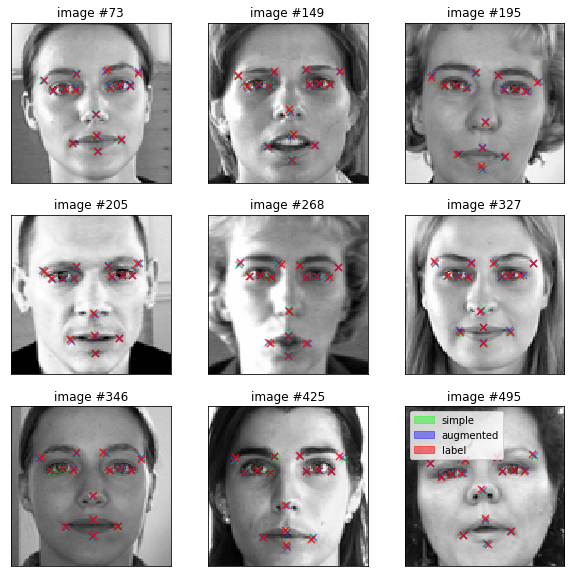

In [69]:
v_lo = np.sort(loss)[8]
indices = np.where(loss <= v_lo)[0]
plot_sample(imgs, predictions, indices, labels)

It is always easier to comment on the bad than on the good, so let us now have a look at the worst examples.

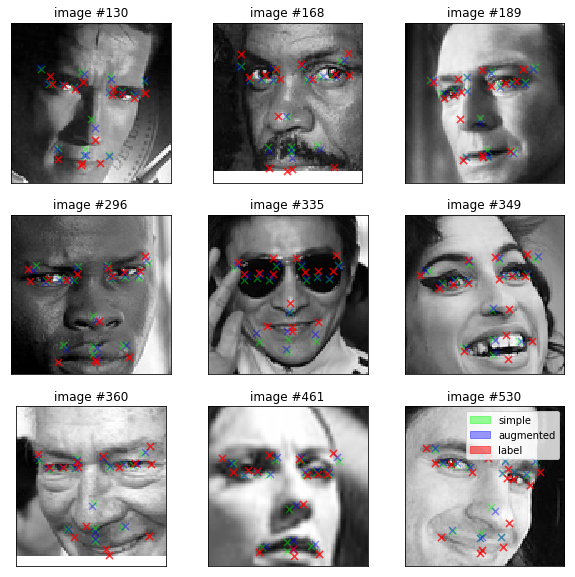

In [68]:
v_lo = np.sort(loss)[-9]
indices = np.where(loss >= v_lo)[0]
plot_sample(imgs, predictions, indices, labels)

Here is our image 296 again. It is rather reassuring to know that such a bad performing example belongs to the top 10 worst examples of our validation dataset. Some features that these examples possess are the following:

* The mouth labels seems to indicate the top of the inside extremities of the lips, whereas for examples that were well predicted, they indicate the outside extremities.
* The subjects are not facing the camera.
* Presence of sunglasses. Only for one example, but this seems to have a huge influence (as expected) on the result.
* Severe cropping of the chin.

Furthermore, it seems that in most cases they possess more than one of these features

Clearly this model could be improved in many ways, such as but not limited to:

* Augmenting the data differently.
* Making use of the incomplete labels (70% of the labels included NAs and were dropped for simplicity, clearly this is not adequate if one wants to achieve the best predictions possible).
* Test different networks architectures and hyperparameters.

However this Kaggle challenge has already been investigated a lot and I will now move on to another project.